In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/ecommerce-text-classification/ecommerceDataset.csv


#### Installing the necassary packages

In [2]:
!pip install contractions

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.5/106.5 kB 4.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 287.5/287.5 kB 15.8 MB/s eta 0:00:00


### 1. Importing libraries

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import nltk
nltk.download('omw-1.4')

import string
import fasttext
import contractions
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
plt.xticks(rotation=70)
pd.options.mode.chained_assignment = None
pd.set_option('display.max_colwidth', 100)
from nltk.stem import PorterStemmer
from nltk.tokenize import sent_tokenize

from wordcloud import WordCloud
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfTransformer

import re

%matplotlib inline

[nltk_data] Downloading package omw-1.4 to /usr/share/nltk_data...


##### Reading the data and labelling the columns

In [4]:
df = pd.read_csv(r'../input/ecommerce-text-classification/ecommerceDataset.csv')

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50424 entries, 0 to 50423
Data columns (total 2 columns):
 #   Column                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 

#### We have two columns as follows: 
1. Labels
2. Description to categorize the labels

In [6]:
df.columns = ['label', 'description']

## 2. Data claeaning

In this part, we will check for the null values and duplicates present in the data. 

### Why is it necessary to remove the null values and duplicates in the dataset?

Duplicate data takes up the unnecessary storage space and slows down te calculation as well. In worst cases, it can also skew the analysis result. 

Now, why null values? Because most of the ML models can produce error while computing if you pass an null value. There are various method to fill the missing values. Before deleting the data or choosing the best method, first we need to analyze the type of missing values and its significance. 

Some of the methods are listed that can be used in such cases: 
1. Deleting the rows/columns with the missing values. 
2. Filling the missing value with mean/median value(If numerical)
3. Filling the missing value with mode value(If categorical)
4. Using regression model 


#### checking for null values in data

In [7]:
df.isnull().sum()

label          0
description    1
dtype: int64

#### Here, only one missing value is present in the description column, thus we will just remove the respective row from the dataset

In [8]:
df = df.dropna(how = 'any', axis='rows')

In [9]:
df.isnull().sum()

label          0
description    0
dtype: int64

#### Dropping duplicates from the data

In [10]:
df.shape

(50423, 2)

In [11]:
df.drop_duplicates(subset=['label','description'],keep='first',inplace=True)
print(df.shape)
df.head(10)

(27801, 2)


,label,description
0,Household,"SAF 'Floral' Framed Painting (Wood, 30 inch x 10 inch, Special Effect UV Print Textured, SAO297)..."
1,Household,"SAF 'UV Textured Modern Art Print Framed' Painting (Synthetic, 35 cm x 50 cm x 3 cm, Set of 3) C..."
2,Household,"SAF Flower Print Framed Painting (Synthetic, 13.5 inch x 22 inch, UV Textured, Set of 3, SANFSW4..."
3,Household,Incredible Gifts India Wooden Happy Birthday Unique Personalized Gift (5 X 4 Inch) Size:4 x 5 ...
4,Household,Pitaara Box Romantic Venice Canvas Painting 6mm Thick Mdf Frame 21.1 X 14Inch Enclosure Material...
5,Household,Paper Plane Design Starry Night Vangoh Wall Art Canvas Painting. Large Size Rolled Canvas Art Pr...
7,Household,"SAF 'Ganesh Modern Art Print' Painting (Synthetic, 35 cm x 50 cm x 2 cm, Set of 3) Color:Multico..."
8,Household,Paintings Villa UV Textured Modern Art Print Framed Painting Home Decoration - Size 35 X 2 X 50 ...
9,Household,Painting Mantra Art Street - Jardin Bird Framed Art Print Set of 4 Black (10 x 10 inch) Color:Co...
12,Household,"Painting Mantra 'Vintage Car' Art Printing Set (Synthetic Wood, 60 cm x 50 cm x 2 cm, Brown, Set..."


## 3. Data visualization

### How many categories are there in the label? What is the count of the categorize in the dataset? 

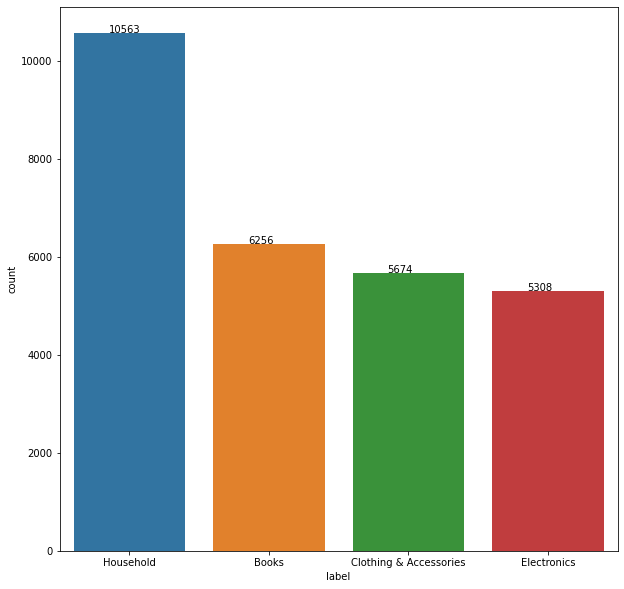

In [12]:

plt.figure(figsize=(10,10))
ax = sns.countplot(x=df["label"],  data=df, order = df["label"].value_counts().index )
for p, label in zip(ax.patches, df["label"].value_counts()):   
    ax.annotate(label, (p.get_x()+0.25, p.get_height()+0.5))

### What words helps in signifying/classifying the labels the most?

In [13]:
mask = df['label'] == "Household"
df_cat1 = df[mask]
mask = df['label']  == "Books"
df_cat2 = df[mask]
mask = df['label'] == "Clothing & Accessories"
df_cat3 = df[mask]
mask = df['label'] == "Electronics"
df_cat4 = df[mask]

#### When label = Household

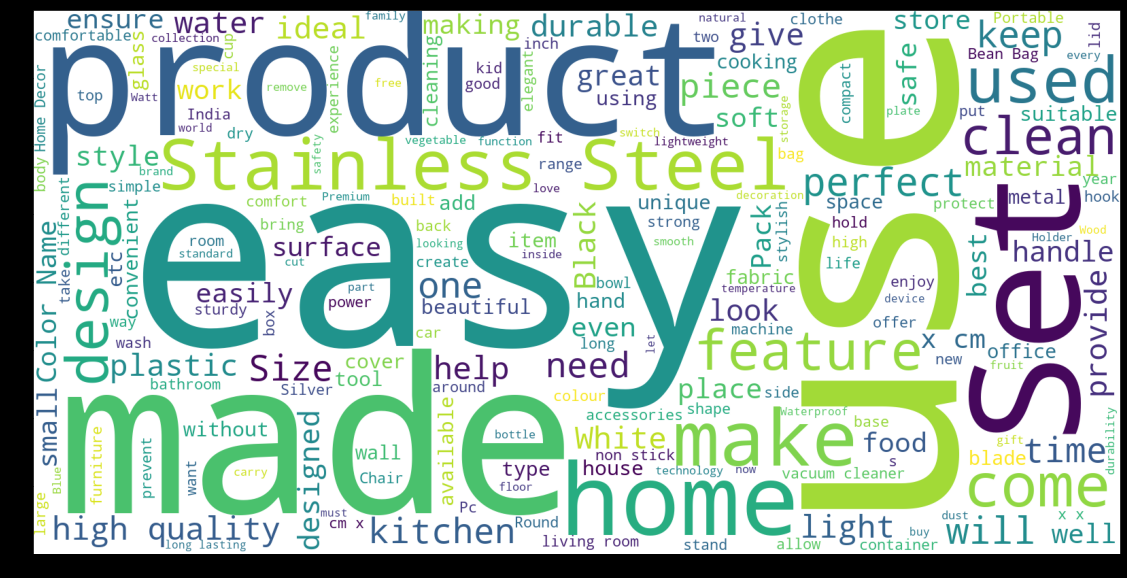

In [14]:
wordcloud = WordCloud(background_color="white",width=1600, height=800).generate(' '.join(df_cat1['description'].tolist()))
plt.figure( figsize=(20,10), facecolor='k')
plt.imshow(wordcloud)

#### When label = Books

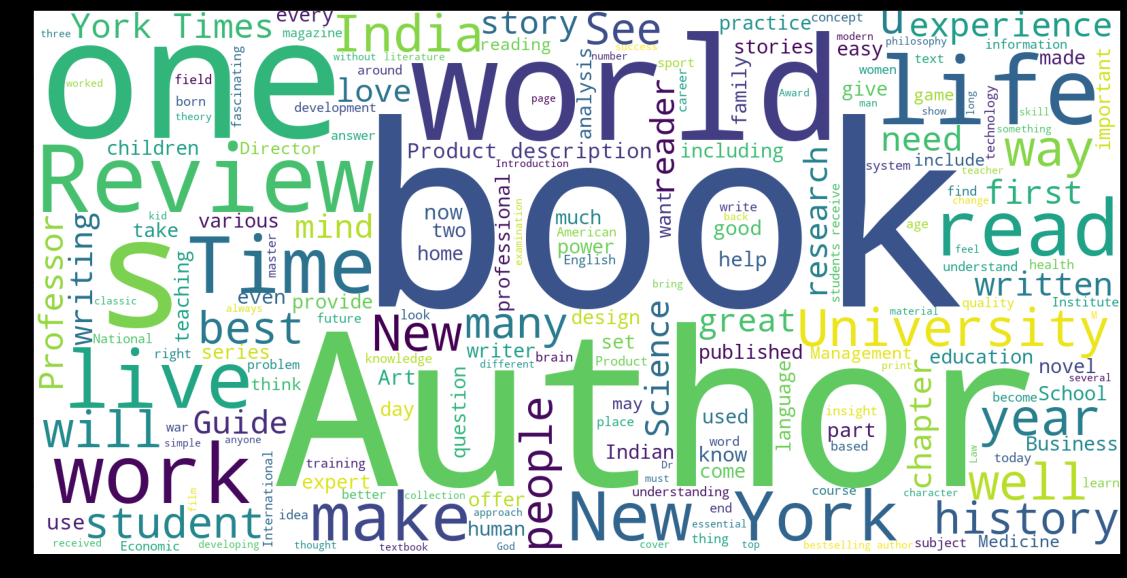

In [15]:
wordcloud = WordCloud(background_color="white",width=1600, height=800).generate(' '.join(df_cat2['description'].tolist()))
plt.figure( figsize=(20,10), facecolor='k')
plt.imshow(wordcloud)

#### When label = Clothing & Accessories

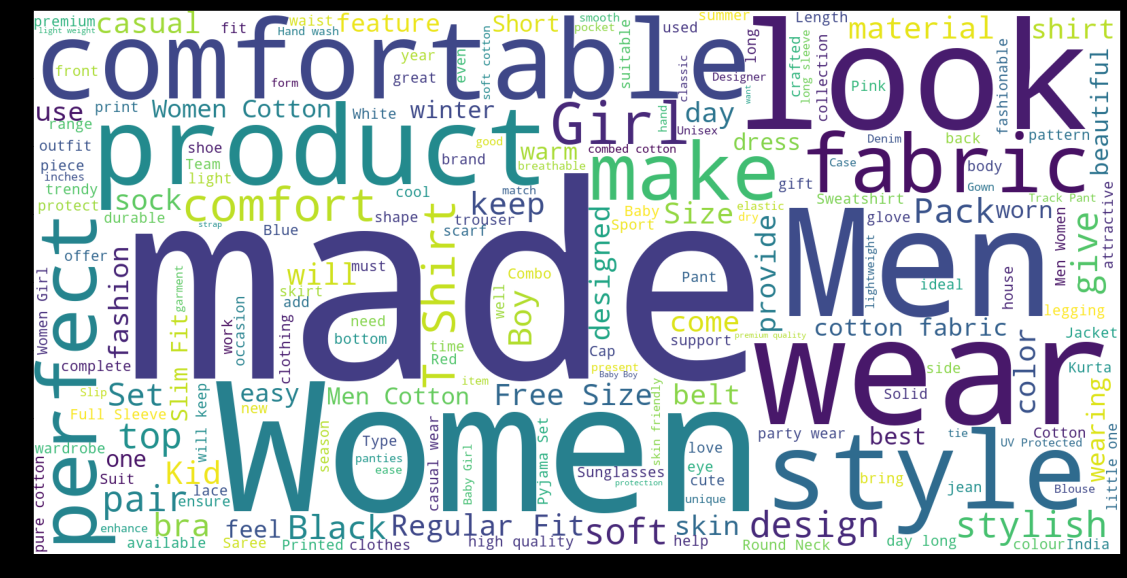

In [16]:
wordcloud = WordCloud(background_color="white",width=1600, height=800).generate(' '.join(df_cat3['description'].tolist()))
plt.figure( figsize=(20,10), facecolor='k')
plt.imshow(wordcloud)

#### When label = Elecronics

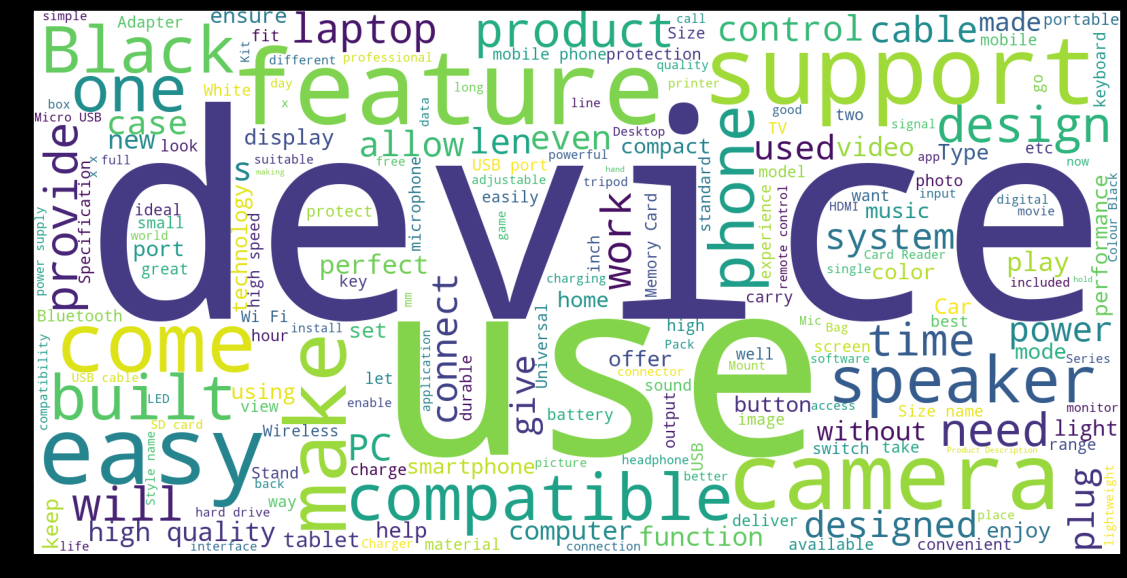

In [17]:
wordcloud = WordCloud(background_color="white",width=1600, height=800).generate(' '.join(df_cat4['description'].tolist()))
plt.figure( figsize=(20,10), facecolor='k')
plt.imshow(wordcloud)

## 4. Data pre-processing
### This is the method to clean the data and make it ready to be applied for the models. 

The method are slightly different in case of text data unlike the usual techniques/methods used in Regression and classification models. 

--Text data contains noise in forms of punctuation, different forms of words, different language and meaningless (for machines ofcourse) symbols which are advised to remove beforehand. 



#### 4.1 Cleaning the data set by `removing the puctuation`

For machine, punctuations are meaningless symbols and do not provide any additional information about the language or text. Thus, we generally prefer to drop all the punctuation. 
* String.punctuation contains a set of 32 punctuations whch can directly be used or any new can also be added in the same depending upon the case. 

In [18]:
def clean_text(text ): 
    delete_dict = {sp_character: '' for sp_character in string.punctuation} 
    delete_dict[' '] = ' ' 
    delete_dict["'"] = "'" 
    table = str.maketrans(delete_dict)
    text1 = text.translate(table)
    textArr= text1.split()
    textArr = re.sub(r'[\.;:,\?\"\'\/]',' ', text1)
    text2 = ''.join([w for w in textArr]) 
    
    return text2

In [20]:
df['description'] = df['description'].apply(clean_text)
df['description'] 

0        SAF  Floral  Framed Painting Wood 30 inch x 10 inch Special Effect UV Print Textured SAO297 Pain...
1        SAF  UV Textured Modern Art Print Framed  Painting Synthetic 35 cm x 50 cm x 3 cm Set of 3 Color...
2        SAF Flower Print Framed Painting Synthetic 135 inch x 22 inch UV Textured Set of 3 SANFSW4951 Co...
3        Incredible Gifts India Wooden Happy Birthday Unique Personalized Gift 5 X 4 Inch Size4 x 5   Mad...
4        Pitaara Box Romantic Venice Canvas Painting 6mm Thick Mdf Frame 211 X 14Inch Enclosure MaterialM...
                                                        ...                                                 
50401    Micromax Bharat 5 Plus Zero impact on visual displayScratch proof Protects screen from shock  bu...
50402    Microsoft Lumia 550 8GB 4G Black Microsoft lumia 550 experience the power of windows 10 at a pri...
50406    Microsoft Lumia 535 Black 8GB ColourBlack   Product Description High Definition Visuals This Sma...
50407    Karbonn Ti

#### 4.2 Tokenization

It is a method to breakdown a sentence into words and similarly, paragraphs into sentences. Those broken words or pieces are called tokens(word/sentence tokens) which helps in understanding the context and create a vocabulary for the case.  

In [21]:
df['tokenize'] = df['description'].apply(word_tokenize)
df.head()

,label,description,tokenize
0,Household,SAF Floral Framed Painting Wood 30 inch x 10 inch Special Effect UV Print Textured SAO297 Pain...,"[SAF, Floral, Framed, Painting, Wood, 30, inch, x, 10, inch, Special, Effect, UV, Print, Texture..."
1,Household,SAF UV Textured Modern Art Print Framed Painting Synthetic 35 cm x 50 cm x 3 cm Set of 3 Color...,"[SAF, UV, Textured, Modern, Art, Print, Framed, Painting, Synthetic, 35, cm, x, 50, cm, x, 3, cm..."
2,Household,SAF Flower Print Framed Painting Synthetic 135 inch x 22 inch UV Textured Set of 3 SANFSW4951 Co...,"[SAF, Flower, Print, Framed, Painting, Synthetic, 135, inch, x, 22, inch, UV, Textured, Set, of,..."
3,Household,Incredible Gifts India Wooden Happy Birthday Unique Personalized Gift 5 X 4 Inch Size4 x 5 Mad...,"[Incredible, Gifts, India, Wooden, Happy, Birthday, Unique, Personalized, Gift, 5, X, 4, Inch, S..."
4,Household,Pitaara Box Romantic Venice Canvas Painting 6mm Thick Mdf Frame 211 X 14Inch Enclosure MaterialM...,"[Pitaara, Box, Romantic, Venice, Canvas, Painting, 6mm, Thick, Mdf, Frame, 211, X, 14Inch, Enclo..."


#### 4.3 changing to lowercase

Transforming the etxt into lower case maintains the consistent flow during the text mining in NLP. It helps in preventing the duplication of the word as well, e.g "Word" & "word" can be treated as different words by the model

In [22]:
df['lower'] = df['tokenize'].apply(lambda x: [word.lower() for word in x])
df.head()

,label,description,tokenize,lower
0,Household,SAF Floral Framed Painting Wood 30 inch x 10 inch Special Effect UV Print Textured SAO297 Pain...,"[SAF, Floral, Framed, Painting, Wood, 30, inch, x, 10, inch, Special, Effect, UV, Print, Texture...","[saf, floral, framed, painting, wood, 30, inch, x, 10, inch, special, effect, uv, print, texture..."
1,Household,SAF UV Textured Modern Art Print Framed Painting Synthetic 35 cm x 50 cm x 3 cm Set of 3 Color...,"[SAF, UV, Textured, Modern, Art, Print, Framed, Painting, Synthetic, 35, cm, x, 50, cm, x, 3, cm...","[saf, uv, textured, modern, art, print, framed, painting, synthetic, 35, cm, x, 50, cm, x, 3, cm..."
2,Household,SAF Flower Print Framed Painting Synthetic 135 inch x 22 inch UV Textured Set of 3 SANFSW4951 Co...,"[SAF, Flower, Print, Framed, Painting, Synthetic, 135, inch, x, 22, inch, UV, Textured, Set, of,...","[saf, flower, print, framed, painting, synthetic, 135, inch, x, 22, inch, uv, textured, set, of,..."
3,Household,Incredible Gifts India Wooden Happy Birthday Unique Personalized Gift 5 X 4 Inch Size4 x 5 Mad...,"[Incredible, Gifts, India, Wooden, Happy, Birthday, Unique, Personalized, Gift, 5, X, 4, Inch, S...","[incredible, gifts, india, wooden, happy, birthday, unique, personalized, gift, 5, x, 4, inch, s..."
4,Household,Pitaara Box Romantic Venice Canvas Painting 6mm Thick Mdf Frame 211 X 14Inch Enclosure MaterialM...,"[Pitaara, Box, Romantic, Venice, Canvas, Painting, 6mm, Thick, Mdf, Frame, 211, X, 14Inch, Enclo...","[pitaara, box, romantic, venice, canvas, painting, 6mm, thick, mdf, frame, 211, x, 14inch, enclo..."


#### 4.4 stop words

These are words (describe in language define by user) that do not add much meaning to a sentence. The can directly be removed from data without affecting the eaning of the sentence eg, for, like , the, a , an etc. 

In [23]:
stop_words = set(stopwords.words('english'))
df['stop_words_removed'] = df['lower'].apply(lambda x: " ".join(i for i in x if i not in stop_words))

df.head()

,label,description,tokenize,lower,stop_words_removed
0,Household,SAF Floral Framed Painting Wood 30 inch x 10 inch Special Effect UV Print Textured SAO297 Pain...,"[SAF, Floral, Framed, Painting, Wood, 30, inch, x, 10, inch, Special, Effect, UV, Print, Texture...","[saf, floral, framed, painting, wood, 30, inch, x, 10, inch, special, effect, uv, print, texture...",saf floral framed painting wood 30 inch x 10 inch special effect uv print textured sao297 painti...
1,Household,SAF UV Textured Modern Art Print Framed Painting Synthetic 35 cm x 50 cm x 3 cm Set of 3 Color...,"[SAF, UV, Textured, Modern, Art, Print, Framed, Painting, Synthetic, 35, cm, x, 50, cm, x, 3, cm...","[saf, uv, textured, modern, art, print, framed, painting, synthetic, 35, cm, x, 50, cm, x, 3, cm...",saf uv textured modern art print framed painting synthetic 35 cm x 50 cm x 3 cm set 3 colormulti...
2,Household,SAF Flower Print Framed Painting Synthetic 135 inch x 22 inch UV Textured Set of 3 SANFSW4951 Co...,"[SAF, Flower, Print, Framed, Painting, Synthetic, 135, inch, x, 22, inch, UV, Textured, Set, of,...","[saf, flower, print, framed, painting, synthetic, 135, inch, x, 22, inch, uv, textured, set, of,...",saf flower print framed painting synthetic 135 inch x 22 inch uv textured set 3 sanfsw4951 color...
3,Household,Incredible Gifts India Wooden Happy Birthday Unique Personalized Gift 5 X 4 Inch Size4 x 5 Mad...,"[Incredible, Gifts, India, Wooden, Happy, Birthday, Unique, Personalized, Gift, 5, X, 4, Inch, S...","[incredible, gifts, india, wooden, happy, birthday, unique, personalized, gift, 5, x, 4, inch, s...",incredible gifts india wooden happy birthday unique personalized gift 5 x 4 inch size4 x 5 made ...
4,Household,Pitaara Box Romantic Venice Canvas Painting 6mm Thick Mdf Frame 211 X 14Inch Enclosure MaterialM...,"[Pitaara, Box, Romantic, Venice, Canvas, Painting, 6mm, Thick, Mdf, Frame, 211, X, 14Inch, Enclo...","[pitaara, box, romantic, venice, canvas, painting, 6mm, thick, mdf, frame, 211, x, 14inch, enclo...",pitaara box romantic venice canvas painting 6mm thick mdf frame 211 x 14inch enclosure materialm...


### 4.5 Stemming & Lemmatization

It is a process to reduce the word to its root stem `eg running, runs, runed to run.` 
In simpler words, it basically removes the prefix and suffix from the words. But sometimes it can result into meaningless words as well. 

--- There are various types of stemming algorithms like porter stemmer, snowball stemmer. Porter stemmer is widely used present in the NLTK library.

This orginates the concept of lemmatization. it takes help of the linguistic analysis of the words. Lemmatization is a systematic way to reduce the words into their lemma by matching them with a language dictionary.

In [24]:
st = PorterStemmer()
df['stemming'] = df['stop_words_removed'].apply(lambda x: " ".join([st.stem(word) for word in x.split()]))
df.head()

,label,description,tokenize,lower,stop_words_removed,stemming
0,Household,SAF Floral Framed Painting Wood 30 inch x 10 inch Special Effect UV Print Textured SAO297 Pain...,"[SAF, Floral, Framed, Painting, Wood, 30, inch, x, 10, inch, Special, Effect, UV, Print, Texture...","[saf, floral, framed, painting, wood, 30, inch, x, 10, inch, special, effect, uv, print, texture...",saf floral framed painting wood 30 inch x 10 inch special effect uv print textured sao297 painti...,saf floral frame paint wood 30 inch x 10 inch special effect uv print textur sao297 paint made s...
1,Household,SAF UV Textured Modern Art Print Framed Painting Synthetic 35 cm x 50 cm x 3 cm Set of 3 Color...,"[SAF, UV, Textured, Modern, Art, Print, Framed, Painting, Synthetic, 35, cm, x, 50, cm, x, 3, cm...","[saf, uv, textured, modern, art, print, framed, painting, synthetic, 35, cm, x, 50, cm, x, 3, cm...",saf uv textured modern art print framed painting synthetic 35 cm x 50 cm x 3 cm set 3 colormulti...,saf uv textur modern art print frame paint synthet 35 cm x 50 cm x 3 cm set 3 colormulticolor si...
2,Household,SAF Flower Print Framed Painting Synthetic 135 inch x 22 inch UV Textured Set of 3 SANFSW4951 Co...,"[SAF, Flower, Print, Framed, Painting, Synthetic, 135, inch, x, 22, inch, UV, Textured, Set, of,...","[saf, flower, print, framed, painting, synthetic, 135, inch, x, 22, inch, uv, textured, set, of,...",saf flower print framed painting synthetic 135 inch x 22 inch uv textured set 3 sanfsw4951 color...,saf flower print frame paint synthet 135 inch x 22 inch uv textur set 3 sanfsw4951 colormulticol...
3,Household,Incredible Gifts India Wooden Happy Birthday Unique Personalized Gift 5 X 4 Inch Size4 x 5 Mad...,"[Incredible, Gifts, India, Wooden, Happy, Birthday, Unique, Personalized, Gift, 5, X, 4, Inch, S...","[incredible, gifts, india, wooden, happy, birthday, unique, personalized, gift, 5, x, 4, inch, s...",incredible gifts india wooden happy birthday unique personalized gift 5 x 4 inch size4 x 5 made ...,incred gift india wooden happi birthday uniqu person gift 5 x 4 inch size4 x 5 made natur import...
4,Household,Pitaara Box Romantic Venice Canvas Painting 6mm Thick Mdf Frame 211 X 14Inch Enclosure MaterialM...,"[Pitaara, Box, Romantic, Venice, Canvas, Painting, 6mm, Thick, Mdf, Frame, 211, X, 14Inch, Enclo...","[pitaara, box, romantic, venice, canvas, painting, 6mm, thick, mdf, frame, 211, x, 14inch, enclo...",pitaara box romantic venice canvas painting 6mm thick mdf frame 211 x 14inch enclosure materialm...,pitaara box romant venic canva paint 6mm thick mdf frame 211 x 14inch enclosur materialmdf mount...


Lemmatization

In [25]:
def lemmatize_text(text):
    wordlist=[]
    lemmatizer = WordNetLemmatizer() 
    sentences=sent_tokenize(text)
    for sentence in sentences:
        words=word_tokenize(sentence)
        for word in words:
            wordlist.append(lemmatizer.lemmatize(word))
    return ' '.join(wordlist) 


In [26]:
df['lemmatized'] = df['stemming'].apply(lemmatize_text)

df.head()

,label,description,tokenize,lower,stop_words_removed,stemming,lemmatized
0,Household,SAF Floral Framed Painting Wood 30 inch x 10 inch Special Effect UV Print Textured SAO297 Pain...,"[SAF, Floral, Framed, Painting, Wood, 30, inch, x, 10, inch, Special, Effect, UV, Print, Texture...","[saf, floral, framed, painting, wood, 30, inch, x, 10, inch, special, effect, uv, print, texture...",saf floral framed painting wood 30 inch x 10 inch special effect uv print textured sao297 painti...,saf floral frame paint wood 30 inch x 10 inch special effect uv print textur sao297 paint made s...,saf floral frame paint wood 30 inch x 10 inch special effect uv print textur sao297 paint made s...
1,Household,SAF UV Textured Modern Art Print Framed Painting Synthetic 35 cm x 50 cm x 3 cm Set of 3 Color...,"[SAF, UV, Textured, Modern, Art, Print, Framed, Painting, Synthetic, 35, cm, x, 50, cm, x, 3, cm...","[saf, uv, textured, modern, art, print, framed, painting, synthetic, 35, cm, x, 50, cm, x, 3, cm...",saf uv textured modern art print framed painting synthetic 35 cm x 50 cm x 3 cm set 3 colormulti...,saf uv textur modern art print frame paint synthet 35 cm x 50 cm x 3 cm set 3 colormulticolor si...,saf uv textur modern art print frame paint synthet 35 cm x 50 cm x 3 cm set 3 colormulticolor si...
2,Household,SAF Flower Print Framed Painting Synthetic 135 inch x 22 inch UV Textured Set of 3 SANFSW4951 Co...,"[SAF, Flower, Print, Framed, Painting, Synthetic, 135, inch, x, 22, inch, UV, Textured, Set, of,...","[saf, flower, print, framed, painting, synthetic, 135, inch, x, 22, inch, uv, textured, set, of,...",saf flower print framed painting synthetic 135 inch x 22 inch uv textured set 3 sanfsw4951 color...,saf flower print frame paint synthet 135 inch x 22 inch uv textur set 3 sanfsw4951 colormulticol...,saf flower print frame paint synthet 135 inch x 22 inch uv textur set 3 sanfsw4951 colormulticol...
3,Household,Incredible Gifts India Wooden Happy Birthday Unique Personalized Gift 5 X 4 Inch Size4 x 5 Mad...,"[Incredible, Gifts, India, Wooden, Happy, Birthday, Unique, Personalized, Gift, 5, X, 4, Inch, S...","[incredible, gifts, india, wooden, happy, birthday, unique, personalized, gift, 5, x, 4, inch, s...",incredible gifts india wooden happy birthday unique personalized gift 5 x 4 inch size4 x 5 made ...,incred gift india wooden happi birthday uniqu person gift 5 x 4 inch size4 x 5 made natur import...,incred gift india wooden happi birthday uniqu person gift 5 x 4 inch size4 x 5 made natur import...
4,Household,Pitaara Box Romantic Venice Canvas Painting 6mm Thick Mdf Frame 211 X 14Inch Enclosure MaterialM...,"[Pitaara, Box, Romantic, Venice, Canvas, Painting, 6mm, Thick, Mdf, Frame, 211, X, 14Inch, Enclo...","[pitaara, box, romantic, venice, canvas, painting, 6mm, thick, mdf, frame, 211, x, 14inch, enclo...",pitaara box romantic venice canvas painting 6mm thick mdf frame 211 x 14inch enclosure materialm...,pitaara box romant venic canva paint 6mm thick mdf frame 211 x 14inch enclosur materialmdf mount...,pitaara box romant venic canva paint 6mm thick mdf frame 211 x 14inch enclosur materialmdf mount...


## 5. Training the model

### 5.1 Naive Bayes Classifier

It is algorithm that classifies text based on the probabillity of occurence of the events. This is basicaly based on the popular "BAYES THOEOREM" which calculates the probability of an event using conditional probability. 

* Naive Bayes for NLP involves preprocessing the text using TF-IDF and then running the multinomial naive Bayes on the preprocessed outputs

In [28]:
counter = Counter(df['label'].tolist())
counter 

Counter({'Household': 10563,
         'Books': 6256,
         'Clothing & Accessories': 5674,
         'Electronics': 5308})

In [29]:
description_list = df['lemmatized'].tolist()

In [30]:
top_10_varieties = {i[0]: idx for idx, i in enumerate(counter.most_common())}

df[df['label'].map(lambda x: x in top_10_varieties)]

varietal_list = [top_10_varieties[i] for i in df['label'].tolist()]

varietal_list = np.array(varietal_list)

varietal_list

array([0, 0, 0, ..., 3, 3, 3])

In [31]:
count_vect = CountVectorizer()
x_train_counts = count_vect.fit_transform(description_list)

tfidf_transformer = TfidfTransformer()
x_train_tfidf = tfidf_transformer.fit_transform(x_train_counts)

Splitting the training and testing dataset

In [32]:
train_x, test_x, train_y, test_y = train_test_split(x_train_tfidf, varietal_list, test_size=0.3)

In [33]:
clf = MultinomialNB().fit(train_x, train_y)
y_score = clf.predict(test_x)

In [34]:
n_right = 0
for i in range(len(y_score)):
    if y_score[i] == test_y[i]:
        n_right += 1

print("Accuracy: %.2f%%" % ((n_right/float(len(test_y)) * 100)))

Accuracy: 91.16%


### 5.2 Support Vector Machine

It is a supervised ML algorithm that categorizes the classes by determining the best hyperplane or boundary line that divides the given dataset into groups. 


In [37]:
from sklearn import svm

In [38]:
clf = svm.SVC(kernel='linear', C= 1.0).fit(train_x, train_y)
y_score = clf.predict(test_x)

In [39]:
 n_right = 0
for i in range(len(y_score)):
    if y_score[i] == test_y[i]:
        n_right += 1

print("Accuracy: %.2f%%" % ((n_right/float(len(test_y)) * 100)))

Accuracy: 95.82%


### 5.3 Deep learning model

 Using Keras with Tensorflow to build our model. 
 *  have to restructure the data in a way that can be easily processed and understood by our neural network
 * replacing the words with uniquely identifying numbers
 * Combined with an embedding vector, we are able to represent the words in a manner that is both flexible and semantically sensitive

In [40]:
from nltk import word_tokenize
from collections import defaultdict

In [41]:
def count_top_x_words(corpus, top_x, skip_top_n):
    count = defaultdict(lambda: 0)
    for c in corpus:
        for w in word_tokenize(c):
            count[w] += 1
    count_tuples = sorted([(w, c) for w, c in count.items()], key=lambda x: x[1], reverse=True)
    return [i[0] for i in count_tuples[skip_top_n: skip_top_n + top_x]]

In [42]:
def replace_top_x_words_with_vectors(corpus, top_x):
    topx_dict = {top_x[i]: i for i in range(len(top_x))}

    return [
        [topx_dict[w] for w in word_tokenize(s) if w in topx_dict]
        for s in corpus
    ], topx_dict

In [43]:
def filter_to_top_x(corpus, n_top, skip_n_top=0):
    top_x = count_top_x_words(corpus, n_top, skip_n_top)
    return replace_top_x_words_with_vectors(corpus, top_x)

To build a model, an embedding layer, a convolutional layer, and a dense layer is needed to take advantage of all of the deep learning features that can be helpful for our application

In [44]:
from keras.models import Sequential
from keras.layers import Dense, Conv1D, Flatten
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
from tensorflow.keras.utils import to_categorical
import pandas as pd
from collections import Counter
from sklearn.model_selection import train_test_split

In [45]:
mapped_list, word_list = filter_to_top_x(description_list, 2500, 10)
max_review_length = 150

varietal_list_cat = to_categorical(varietal_list)

mapped_list = sequence.pad_sequences(mapped_list, maxlen=150)

train_x, test_x, train_y, test_y = train_test_split(mapped_list, varietal_list_cat, test_size=0.3)

In [46]:
train_x.shape

(19460, 150)

In [47]:
model = Sequential()
model.add(Embedding(2500, 64, input_length=150))

model.add(Conv1D(50, 5))
model.add(Flatten())
model.add(Dense(100, activation='relu'))
model.add(Dense(max(varietal_list) + 1, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(train_x, train_y, epochs=3, batch_size=64)


2022-09-27 18:16:09.692954: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.
2022-09-27 18:16:09.910047: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/3
305/305 [==============================] - 8s 22ms/step - loss: 0.4423 - accuracy: 0.8480
Epoch 2/3
305/305 [==============================] - 6s 21ms/step - loss: 0.1711 - accuracy: 0.9523
Epoch 3/3
305/305 [==============================] - 7s 21ms/step - loss: 0.0899 - accuracy: 0.9754


In [48]:
y_score = model.predict(test_x)

y_score = [[1 if i == max(sc) else 0 for i in sc] for sc in y_score]

n_right = 0
for i in range(len(y_score)):
    if all(y_score[i][j] == test_y[i][j] for j in range(len(y_score[i]))):
        n_right += 1

In [49]:
print("Accuracy: %.2f%%" % ((n_right/float(len(test_y)) * 100)))

Accuracy: 91.18%


# 6. Result

## Accuracy of Naive Bayes model: 91.16%
## Accuracy of SVM model: 95.82%
## Accuracy of Deep learning model: 91.18% 